In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#  pip install --upgrade scipy networkx

# 1. Data

In [2]:
df_hero_net = pd.read_csv(r"hero-network.csv")
df_edges = pd.read_csv(r"edges.csv")
df_nodes = pd.read_csv(r"nodes.csv")

In [3]:
df_hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE /
574464,CALLISTO,CALIBAN/
574465,CALIBAN/,ROGUE /


In [4]:
df_edges

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [5]:
df_nodes

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


In [6]:
df_nodes.shape

(19090, 2)

In [7]:
n_comics = df_nodes[df_nodes.type == 'comic'].count()
n_heros = df_nodes[df_nodes.type == 'hero'].count()
print(n_comics, n_heros)

node    12651
type    12651
dtype: int64 node    6439
type    6439
dtype: int64


## 1.1 Pre-processing 

In [8]:
df_hero_net["hero1"] = df_hero_net["hero1"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)
df_hero_net["hero2"] = df_hero_net["hero2"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [9]:
df_hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


In [10]:
df_edges["hero"] = df_edges["hero"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [11]:
hero = set(df_edges.hero)
hero_union = set(df_hero_net.hero1).union(set(df_hero_net.hero2))

diff = hero_union - hero.intersection(hero_union)
diff

{'SPIDER-MAN/PETER PAR'}

In [12]:
def jaccard_similarity(setA, setB):
    ''' 
    This function simply computes the Jaccard similarity from its definition.
    '''
    return len(set(setA).intersection(setB))/len(set(setA).union(setB))

In [13]:
for hero in set(df_edges.hero):
    for elem in diff:
        sim = jaccard_similarity(set(elem), set(hero))
        if sim >= 0.5:
            df_hero_net = df_hero_net.replace(elem, hero)

df_hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


In [14]:
# test
hero = set(df_edges.hero)
hero_union = set(df_hero_net.hero1).union(set(df_hero_net.hero2))

diff = hero_union - hero.intersection(hero_union)
diff

set()

In [15]:
print(len(hero_union), len(hero.intersection(hero_union))) # all heroes' names in 'hero-network.csv' are now found in 'edges.csv'

6420 6420


## 1.2 First graph

In [16]:
G1 = nx.MultiGraph()

In [17]:
df_hero_net.apply(lambda row: G1.add_edge(row['hero1'], row['hero2']), axis=1)

0          0
1          0
2          0
3          1
4          1
          ..
574462    27
574463    22
574464     8
574465    11
574466     1
Length: 574467, dtype: int64

In [18]:
#drop sefl-loops
G1.remove_edges_from(nx.selfloop_edges(G1))

In [19]:
list(G1.edges())[:10]

[('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', "BLACK PANTHER/T'CHAL"),
 ('LITTLE, ABNER', "BLACK PANTHER/T'CHAL")]

In [20]:
dicOfOccurances = {}
for h1,h2 in df_hero_net.to_numpy():
    if h1 != h2:
        if (h1,h2) in dicOfOccurances:
            dicOfOccurances[(h1,h2)] += 1
        else:
            dicOfOccurances[(h1,h2)] = 1

In [21]:
G1_weighted = nx.MultiGraph()

In [22]:
i = 0
for edge in list(G1.edges()):
    try:
        G1_weighted.add_edge(edge[0], edge[1], weight = 1/dicOfOccurances[edge])
    except:
        G1_weighted.add_edge(edge[0], edge[1], weight = 1/dicOfOccurances[(edge[1], edge[0])])


In [23]:
edges, weights = zip(*nx.get_edge_attributes(G1_weighted, 'weight').items())
for i in range(20):
    print((edges[i], weights[i]))

(('LITTLE, ABNER', 'PRINCESS ZANDA', 0), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 1), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 2), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 3), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 4), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 5), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 6), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 7), 0.2)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 0), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 1), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 2), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 3), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 4), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 5), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 6), 0.25)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 0), 0.3333333333333333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 1), 0.3333333333333333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 2), 0.3333333333333333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 3), 0.33333333333

In [26]:
G1_weighted2 = nx.Graph(G1_weighted)

In [27]:
edges, weights = zip(*nx.get_edge_attributes(G1_weighted2, 'weight').items())
for i in range(20):
    print((edges[i], weights[i]))

(('LITTLE, ABNER', 'PRINCESS ZANDA'), 0.2)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL"), 0.25)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR'), 0.3333333333333333)
(('LITTLE, ABNER', 'IRON MAN/TONY STARK'), 1.0)
(('LITTLE, ABNER', 'GOLDEN-BLADE'), 1.0)
(('LITTLE, ABNER', 'DIXON, GENERAL'), 1.0)
(('LITTLE, ABNER', 'IRON MAN IV/JAMES R.'), 1.0)
(('LITTLE, ABNER', 'JOCASTA'), 1.0)
(('LITTLE, ABNER', 'FUJIKAWA, RUMIKO'), 1.0)
(('LITTLE, ABNER', 'MADAME MENACE/SUNSET'), 1.0)
(('LITTLE, ABNER', 'JACOBS, GLENDA'), 1.0)
(('LITTLE, ABNER', 'WAR MACHINE II/PARNE'), 1.0)
(('LITTLE, ABNER', 'SAPPER'), 1.0)
(('LITTLE, ABNER', 'HOGAN, VIRGINIA PEPP'), 1.0)
(('LITTLE, ABNER', 'BINARY/CAROL DANVERS'), 1.0)
(('LITTLE, ABNER', 'FIN FANG FOOM/MIDGAR'), 1.0)
(('LITTLE, ABNER', 'MANN, DR. J. VERNON'), 0.5)
(('LITTLE, ABNER', 'THOR/DR. DONALD BLAK'), 1.0)
(('LITTLE, ABNER', 'TEMPEST II/NICOLETTE'), 1.0)
(('LITTLE, ABNER', 'JARVIS, EDWIN'), 1.0)


In [28]:
dicOfWeights = {}
for edge in G1_weighted2.edges():
    dicOfWeights[edge] = G1_weighted2.get_edge_data(edge[0], edge[1])['weight']

In [ ]:
fig = plt.figure(figsize=(18,18))
nx.draw(G1_weighted2, with_labels=True,node_size=300)
plt.show()

## 1.3 Second graph

In [41]:
attributes = {}
for elem,type in df_nodes.to_numpy():
    attributes[elem] = {'type' : type } 
G2 = nx.from_pandas_edgelist(df_edges, 'hero', 'comic')
nx.set_node_attributes(G2, attributes)
edges, types = zip(*nx.get_node_attributes(G2, 'type').items())
for i in range(10):
    print(edges[i], types[i])

24-HOUR MAN/EMMANUEL hero
AA2 35 comic
3-D MAN/CHARLES CHAN hero
AVF 4 comic
AVF 5 comic
COC 1 comic
H2 251 comic
H2 252 comic
M/PRM 35 comic
M/PRM 36 comic


In [ ]:
fig = plt.figure(figsize=(18,18))
nx.draw(G2, with_labels=True,node_size=300)
plt.show()

In [33]:
topN_heroes = df_edges.groupby('hero').count().sort_values(by='comic', ascending=False).head(10)
topN_heroes
# this are the top N heroes ( in this case the top 10) of the heroes that apperar in the most comics the G2 graph

,comic
hero,
SPIDER-MAN/PETER PARKER,1577
CAPTAIN AMERICA,1334
IRON MAN/TONY STARK,1150
THING/BENJAMIN J. GR,963
THOR/DR. DONALD BLAK,956
HUMAN TORCH/JOHNNY S,886
MR. FANTASTIC/REED R,854
HULK/DR. ROBERT BRUC,835
WOLVERINE/LOGAN,819


In [63]:
for G in [G1_weighted2, G2]:
    if G == G1_weighted2:
        print("G1_weighted2")
        def top_N(df, N):
            return df.groupby("hero", group_keys=False).count().sort_values(by='comic', ascending = False).head(N)
        def create_G_topN(G, N, df):
            G_topN = G.copy()
            most_popular_heros = top_N(df, N)
            notInTopN = set(G.nodes()) - set(most_popular_heros.index)
            G_topN.remove_nodes_from(notInTopN)
            return G_topN
        G1_topN = create_G_topN(G1_weighted2, 10, df_edges)
    else:
        print("G2")
        def top_N(df, N):
            return df.groupby("hero", group_keys=False).count().sort_values(by='comic', ascending = False).head(N)
        def create_G_topN(G, N, df):
            G_topN = G.copy()
            most_popular_heros = top_N(df, N)
            notInTopN = set(G.nodes()) - set(most_popular_heros.index)
            G_topN.remove_nodes_from(notInTopN)
            return G_topN
        G2_topN = create_G_topN(G2, 10, df_edges)

#G_topN = create_G_topN(G1_weighted2, 10, df_edges)
#print(len(G_topN.edges()),len(G1_weighted2.edges()))

G1_weighted2
G2


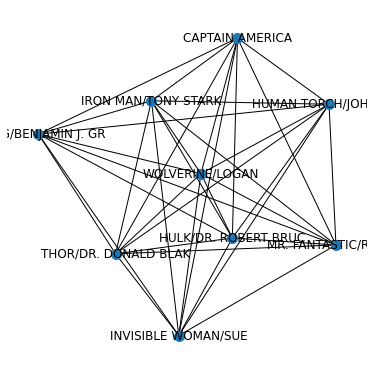

In [67]:
# recall the function to see the G1 graph with the top 10 heroes
fig = plt.figure(figsize=(5,5))
nx.draw(G1_topN, with_labels=True,node_size=100)
plt.show()

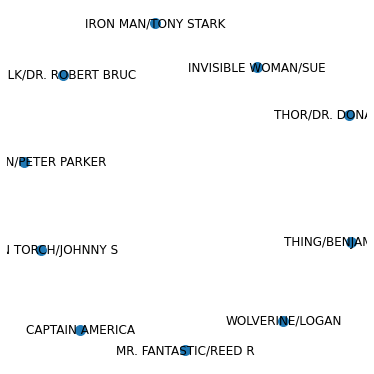

In [69]:
# recall the function to see the G2 graph with the top 10 heroes
fig = plt.figure(figsize=(5,5))
nx.draw(G2_topN, with_labels=True,node_size=100)
plt.show()

In [62]:
G_topN = create_G_topN(G2, 11, df_edges)
print(nx.info(G_topN))


Graph with 11 nodes and 0 edges


C:\Users\elisa\AppData\Local\Temp\ipykernel_22984\1933380785.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G_topN))


# 2. Backend Implementation

## Functionality 1 - extract the graph's features

The number of nodes in the network (if type 2, report for both node types)

In [25]:
n_nodesG1 = int(G1_weighted2.number_of_nodes())
print("Total number of nodes of G1: ", n_nodesG1)
# the total number of nodes in G1 is 6420

Total number of nodes of G1:  6420


In [26]:
count_hero = 0
count_comic = 0
for elements in types:
    if elements == 'hero':
        count_hero += 1
    elif elements == 'comic':
        count_comic += 1
print("the number of heros in G2 is:", count_hero)
print("the number of comics in G2 is:", count_comic)
# the total number of nodes in G2 of heroes  is 6007 and comics is 12651.

the number of heros in G2 is: 6007
the number of comics in G2 is: 12651


The number of collaborations of each superhero with the others

In [27]:
degree_G1 = G1_weighted2.degree()
#print("collaborations of each node:", degree_G1)
# we can see for each hero the collaboration that one has with other heros
# sorting it by the number of collaborations 
sorted_degree_G1 = sorted(degree_G1, key=lambda x: x[1], reverse=True)
#take just the first 10
sorted_degree_G1 = sorted_degree_G1[:10]
print("sorted collaborations of each node:", sorted_degree_G1)


#len(G1_weighted.edges(hero))
# we can see for each hero the collaboration that one has with other heros

sorted collaborations of each node: [('CAPTAIN AMERICA', 1902), ('BLUE DIAMOND/PROFESS', 1755), ('IRON MAN/TONY STARK', 1521), ('THING/BENJAMIN J. GR', 1415), ('MR. FANTASTIC/REED R', 1376), ('WOLVERINE/LOGAN', 1368), ('HUMAN TORCH/JOHNNY S', 1360), ('SCARLET WITCH/WANDA', 1322), ('THOR/DR. DONALD BLAK', 1289), ('BEAST/HENRY &HANK& P', 1265)]


The number of heroes that have appeared in each comic (only if type 2)

In [28]:
#number of heroes that have appeared in each comic of G2
hero_appeard = df_edges.groupby('comic').count().sort_values(by='hero', ascending=False)
print( "the number of heroes that have appeared in each comic of G2:" , "\n", hero_appeard)

the number of heroes that have appeared in each comic of G2: 
                   hero
comic                 
COC 1              111
IW 3                91
IW 1                90
H2 279              87
IW 4                80
...                ...
MYSTIC COMICS 10     1
N 2/4                1
N 37                 1
N 4/2                1
rse powers.          1

[12651 rows x 1 columns]


In [29]:
print("The most popular hero is:", max(G2.degree(), key=lambda x: x[1])[0])
# the most popular hero that apperas in a comic is Spiderman

The most popular hero is: SPIDER-MAN/PETER PARKER


The network's density

In [30]:
# calculate the density from scratch without nx of G1
densityG1 = len(G1_weighted2.edges())/(n_nodesG1*(n_nodesG1-1)/2)
print("The density of G1 is:", densityG1)
# density of G2
densityG2 = len(G2.edges())/(count_hero*(count_hero-1)/2)
print("The density of G2 is:", densityG2)

The density of G1 is: 0.008108958072777516
The density of G2 is: 0.005327561844958216


In [57]:
#checked the density of G1 and G2 with nx
#densityG1 = nx.density(G1_weighted2)
# network density of G1
#print("Network density of G1: ", densityG1)
#densityG2 = nx.density(G2)
#print("Network density of G2: ", densityG2)
# network density of G2

The network's degree distribution

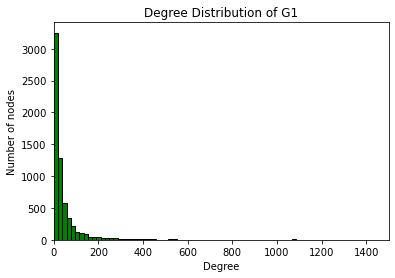

None


In [31]:
def degree_distG1(G1_weighted2):
    degree_G1 = [G1_weighted2.degree(n) for n in G1_weighted2.nodes()]
    plt.hist(degree_G1, bins=100, color='green', edgecolor='black')
    plt.xlim(0, 1500)
    plt.title('Degree Distribution of G1')
    plt.ylabel('Number of nodes')
    plt.xlabel('Degree')
    plt.show()
print(degree_distG1(G1_weighted2))
# we can see from the plot that the distribution of the degrees of G1 is very skewed to the right this means that there are some
# nodes that are very connected and play an important role within the network.
# From the other side the distribution of the degrees shows  a lower peak at a very low degree, 
# the network is less connected and the nodes have less interactions between them, also there are some nodes that are not connected at all.

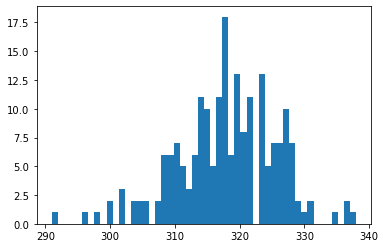

None


In [71]:
#print(degree_distG1(nx.gnp_random_graph(200, 0.8, directed=True)))

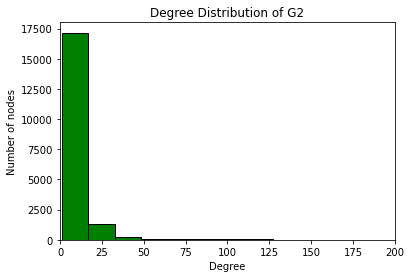

None


In [32]:
def degree_distG2(G2):
    degree_G2 = [G2.degree(n) for n in G2.nodes()]
    plt.hist(degree_G2, bins=100, color='green', edgecolor='black')
    plt.xlim(0, 200)
    plt.title('Degree Distribution of G2')
    plt.ylabel('Number of nodes')
    plt.xlabel('Degree')
    plt.show()
print(degree_distG2(G2))

In [ ]:
#degree_G2 = list(G2.degree())
#print("Degree for all nodes:", degree_G2)
#sorted_degreeG2 = sorted((i for x, i in degree_G2), reverse=True)

The average degree of the network

In [33]:
degree_sequence = [deg for i, deg in G1_weighted2.degree()]
avg_degreeG1 = sum(degree_sequence) / len(degree_sequence)
print("Average degree of G1: ", avg_degreeG1)

Average degree of G1:  52.05140186915888


In [34]:
# average degree of G2
degree_sequence = [deg for i, deg in G2.degree()]
avg_degreeG2 = sum(degree_sequence) / len(degree_sequence)
print("Average degree of G2: ", avg_degreeG2)

Average degree of G2:  10.070100068109184


The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)


In [ ]:
#def hubs(G,type_, N):
    #degree_seq = []
    #for n in G:
        #degree_seq[n] = len(G[n])
        #degree_values = np.array(list(sorted((degree_seq.values()))))
        #perc95 = np.percentile(degree_values, 95)
        #if type_ == 1:
            #hubs = [n for n, degree_seq[n] in degree_seq.items() if degree_seq >= perc95][:N]
        #elif type_ == 2:
            #hubs = [n for n, degree_seq in n_comics.items() if degree_seq >= perc95][:N]
        #return hubs
#print(hubs(G1_weighted2,
# the top 10 hubs of G1
#print(hubs(G2,2,10))
# the top 10 hubs of G2

In [35]:
# print the heroes that are hubs from the most popular to  Nth most popular
def hubsG1(G1_weighted2):
    degreeG1 = [G1_weighted2.degree(n) for n in G1_weighted2.nodes()]
    ex_nodes = [n for n in G1_weighted2.nodes() if G1_weighted2.degree(n) > np.percentile(degreeG1,95)]
    return(ex_nodes)
print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubsG1(G1_weighted)))


Nodes with degrees more extensive than the 95th percentile of the degree distribution:  319


In [36]:
print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubsG1(G1_weighted)), "\n", sorted(hubsG1(G1_weighted2), key=lambda x: G1_weighted2.degree(x), reverse=True)[:10])

Nodes with degrees more extensive than the 95th percentile of the degree distribution:  319 
 ['CAPTAIN AMERICA', 'BLUE DIAMOND/PROFESS', 'IRON MAN/TONY STARK', 'THING/BENJAMIN J. GR', 'MR. FANTASTIC/REED R', 'WOLVERINE/LOGAN', 'HUMAN TORCH/JOHNNY S', 'SCARLET WITCH/WANDA', 'THOR/DR. DONALD BLAK', 'BEAST/HENRY &HANK& P']


In [37]:
def hubs(G2):
    degreeG2 = [G2.degree(n) for n in G2.nodes()]
    ex_nodes = [n for n in G2.nodes() if G2.degree(n) > np.percentile(degreeG2,95) and G2.nodes[n].get('type', '') == 'comic']
    return(ex_nodes)

print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubs(G2)))


Nodes with degrees more extensive than the 95th percentile of the degree distribution:  258


In [38]:
print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubs(G2)), "\n",
sorted(hubs(G2), key=lambda x: G2.degree(x), reverse=True)[:10])


Nodes with degrees more extensive than the 95th percentile of the degree distribution:  258 
 ['COC 1', 'IW 3', 'IW 1', 'H2 279', 'IW 4', 'IW 2', 'MAXSEC 3', 'FF 370', 'IW 6', 'M/GN 1']


Whether the Network is sparse or dense

In [39]:
type_graphG1 = ""    
def density_G1(G1_weighted2):
    n = G1_weighted2.number_of_nodes()
    m = G1_weighted2.number_of_edges()
    return 2*m/(n*(n-1))
if density_G1(G1_weighted2) >= 0.5:
    type_graphG1 = "DENSE"
else:
    type_graphG1 = "SPARSE"
print("The type of G1 is: ", type_graphG1)
# G1 is sparse


The type of G1 is:  SPARSE


In [40]:
type_graphG2 = ""
def density_G2(G2):
    n = G2.number_of_nodes()
    m = G2.number_of_edges()
    return 2*m/(n*(n-1))
if density_G2(G2) >= 0.5:
    type_graphG2 = "DENSE"
else:
    type_graphG2 = "SPARSE"
print("The type of G2 is: ", type_graphG2)
#G2 is sparse

The type of G2 is:  SPARSE


functionality1 of G1:
Number of nodes of G1:  6420
sorted collaborations of each node: [('CAPTAIN AMERICA', 1902), ('BLUE DIAMOND/PROFESS', 1755), ('IRON MAN/TONY STARK', 1521), ('THING/BENJAMIN J. GR', 1415), ('MR. FANTASTIC/REED R', 1376), ('WOLVERINE/LOGAN', 1368), ('HUMAN TORCH/JOHNNY S', 1360), ('SCARLET WITCH/WANDA', 1322), ('THOR/DR. DONALD BLAK', 1289), ('BEAST/HENRY &HANK& P', 1265)]
The density of G1 is: 0.008108958072777516


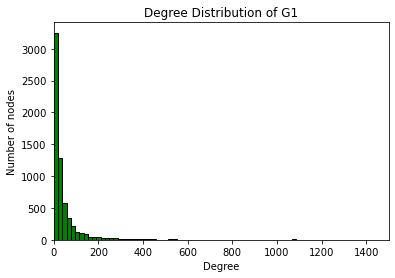

None
Average degree of G1:  52.05140186915888
Nodes with degrees more extensive than the 95th percentile of the degree distribution:  0 
 ['CAPTAIN AMERICA', 'BLUE DIAMOND/PROFESS', 'IRON MAN/TONY STARK', 'THING/BENJAMIN J. GR', 'MR. FANTASTIC/REED R', 'WOLVERINE/LOGAN', 'HUMAN TORCH/JOHNNY S', 'SCARLET WITCH/WANDA', 'THOR/DR. DONALD BLAK', 'BEAST/HENRY &HANK& P']
The type of G1 is:  SPARSE
functionality1 of G2:
Number of nodes of G2:  6007 12651
the number of heroes that have appeared in each comic of G2: 
                   hero
comic                 
COC 1              111
IW 3                91
IW 1                90
H2 279              87
IW 4                80
...                ...
MYSTIC COMICS 10     1
N 2/4                1
N 37                 1
N 4/2                1
rse powers.          1

[12651 rows x 1 columns]
The density of G1 is: 0.005327561844958216


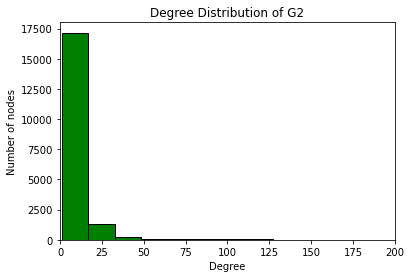

None
Average degree of G2:  10.070100068109184
Nodes with degrees more extensive than the 95th percentile of the degree distribution:  258 
 ['COC 1', 'IW 3', 'IW 1', 'H2 279', 'IW 4', 'IW 2', 'MAXSEC 3', 'FF 370', 'IW 6', 'M/GN 1']
The type of G2 is:  SPARSE


In [41]:
for G in [G1, G2]:
    if G == G1:
        print("functionality1 of G1:")
        print("Number of nodes of G1: ", n_nodesG1)
        print("sorted collaborations of each node:", sorted_degree_G1)
        print("The density of G1 is:", densityG1)
        print(degree_distG1(G1_weighted2))
        print("Average degree of G1: ", avg_degreeG1)
        print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubs(G1_weighted)), 
        "\n", sorted(hubsG1(G1_weighted2), key=lambda x: G1_weighted2.degree(x), reverse=True)[:10])
        print("The type of G1 is: ", type_graphG1)
    else:
        print("functionality1 of G2:")
        print("Number of nodes of G2: ", count_hero, count_comic)
        print( "the number of heroes that have appeared in each comic of G2:" , "\n", hero_appeard)
        print("The density of G1 is:", densityG2)
        print(degree_distG2(G2))
        print("Average degree of G2: ", avg_degreeG2)
        print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubs(G2)),
         "\n", sorted(hubs(G2), key=lambda x: G2.degree(x), reverse=True)[:10])    
        print("The type of G2 is: ", type_graphG2)

# Functionality 2 - Find top superheroes!

The metric's value over the considered graph

In [42]:
from collections import deque
from collections import defaultdict
import random

In [62]:
def BFS(G, s, t):
  queue = deque([s])
  visited = set()
  while queue:
    u = queue.popleft()
    if u not in visited:
      visited.add(u)
      for v in G2[u]:
        queue.append(v)
        if v == t:
          return visited
  return visited
def fun_betweenness_centrality(G):
  betweenness = defaultdict(int)
  for i, s in enumerate(G):
    if i == 10:
      break
    for j, t in enumerate(G):
      if j == 10:
        break
      if s != t:
        # Calcolo i percorsi minimi tra s e t utilizzando l'algoritmo BFS
        path = BFS(G, s, t)
        for v in path:
          betweenness[v] += 1
  # Normalizza i valori della betweenness
  n = len(G)
  for v in betweenness:
    betweenness[v] /= (n-1)*(n-2)
  return betweenness
result = fun_betweenness_centrality(G)
####### Stampa solo i primi 10 elementi del dizionario
#for i, (nodo, valore) in enumerate(result.items()):
  #if i == 10:
    #break
  #print(f"{nodo}: {valore}")

In [63]:
def fun_degree_centrality(G, node):
  num_neighbors = len(list(G.neighbors(node)))
  fun_degree_centrality = num_neighbors / (len(G) - 1)
  return fun_degree_centrality
# doing it for the first 10 nodes
#for i, node in enumerate(G.nodes()):
  #if i == 10:
    #break
  #print(f"{node}: {fun_degree_centrality(G, node)}")

In [ ]:
# Calculate the degree centrality for the graph with networkx to check results:
#degree_cen = nx.degree_centrality(G)
#count = 0
#for node, value in degree_cen.items():
    #Print the degree centrality for the current node
    #print(f"{node}: {value}")
    #count += 1
    #if count == 10:
        #break

In [64]:
#PageRank centrality
def fun_pagerank_centrality(G, alpha=0.85, max_iter=100, tol=1e-6):
  # Inizializza i valori di PageRank di ogni nodo con 1/n, dove n è il numero di nodi del grafo
  n = len(G)
  pagerank = {node: 1/n for node in G}
  # Itera finché non si raggiunge la convergenza o il numero massimo di iterazioni
  for i in range(max_iter):
    diff = 0
    # Calcola il nuovo valore di PageRank per ogni nodo
    for node in pagerank:
      rank = sum(pagerank[neighbor] / len(G[neighbor]) for neighbor in G[node])
      # Aggiorna il valore di PageRank del nodo utilizzando la formula di PageRank
      new_rank = (1 - alpha) / n + alpha * rank
      diff += abs(new_rank - pagerank[node])
      pagerank[node] = new_rank
    # Se la differenza è minore della soglia di tolleranza, interrompi il loop
    if diff < tol:
      break
  return pagerank

#### stampo i risultati per i primi 10 nodi
#result = fun_pagerank_centrality(G)
#for i, (node, value) in enumerate(result.items()):
 # if i == 10:
  #  break
  #print(f"{node}: {value}")

In [65]:
#calculate pagerank centrality with networkx
pagerank = nx.pagerank(G)
count = 0
for node, value in pagerank.items():
    print(f"{node}: {value}")
    count += 1
    if count == 10:
        break

LITTLE, ABNER: 6.452465203471656e-05
PRINCESS ZANDA: 4.920646245698957e-05
BLACK PANTHER/T'CHAL: 0.00248473210033786
STEELE, SIMON/WOLFGA: 4.999670048268568e-05
FORTUNE, DOMINIC: 7.495870448327506e-05
ERWIN, CLYTEMNESTRA: 0.0001608244323661501
IRON MAN/TONY STARK: 0.00818213698079298
IRON MAN IV/JAMES R.: 0.001767812141042685
RAVEN, SABBATH II/EL: 5.632943958935856e-05
CARNIVORE/COUNT ANDR: 0.00011542096157614045


In [66]:
def fun_closeness_centrality(G, node):
  # Inizializza una coda e un dizionario per tenere traccia della distanza di ogni nodo dal nodo in questione
  queue = deque([node])
  distances = {node: 0}

  # Esegue la ricerca in larghezza a partire dal nodo in questione
  while queue:
    current_node = queue.popleft()
    for neighbor in G[current_node]:
      if neighbor not in distances:
        distances[neighbor] = distances[current_node] + 1
        queue.append(neighbor)

  # Calcola la somma delle distanze di tutti i nodi dal nodo in questione
  total_distance = sum(distances.values())
  # Calcola la centralità di prossimità come il numero di nodi del grafo diviso dalla somma delle distanze
  closeness_centrality = len(G) / total_distance
  return closeness_centrality

In [ ]:
# stampo i risultati per i primi 10 nodi
#for i, node in enumerate(G.nodes()):
 # if i == 10:
  #  break
  #print(f"{node}: {fun_closeness_centrality(G, node)}")

In [ ]:
# calculate the closeness centrality with networkx
#closeness = nx.closeness_centrality(G)
#stampo i risultati per i primi 10 nodi
#count = 0
#for node, value in closeness.items():
 #   print(f"{node}: {value}")
  #  count += 1
   # if count == 10:
    #    break

In [ ]:
for G in [G1_topN, G2_topN]:
    for nodo in G.nodes() and N:
        print("the node is: ", nodo)
    if G == G1_topN:
        print(" the betweenness centrality of G1: ", fun_betweenness_centrality(G1))
        print(" the degree centrality of G1: ", fun_degree_centrality(G1, nodo))
        print(" the pagerank centrality of G1: ", fun_pagerank_centrality(G1))
        print(" the closeness centrality of G1: ", fun_closeness_centrality(G1, top_n_heroes))
    else:
        print(" the betweenness centrality of G2: ", fun_betweenness_centrality(G2))
        print(" the degree centrality of G2: ", fun_degree_centrality(G2, nodo))
        print(" the pagerank centrality of G2: ", fun_pagerank_centrality(G2))
        print(" the closeness centrality of G2: ", fun_closeness_centrality(G2, topN_heroes))


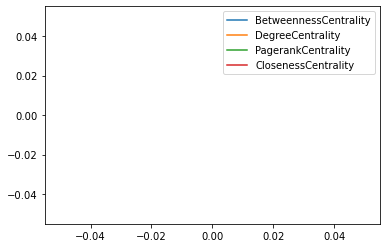

In [212]:
# comparing the results of the different centrality measures:
measures = [fun_betweenness_centrality, fun_degree_centrality, fun_pagerank_centrality, fun_closeness_centrality]

# Create a list of labels for the measures
labels = ['BetweennessCentrality', 'DegreeCentrality', 'PagerankCentrality','ClosenessCentrality']

# Plot the measures
for measure, label in zip(measures, labels):
    # Get the measure values as a dictionary
    measure_values = nx.get_node_attributes(G, measure)
    # Normalize the measure values by dividing them by the maximum value
    normalized_values = {node: value/max(measure_values.values()) for node, value in measure_values.items()}
    # Plot the normalized measure values
    plt.plot(normalized_values.values(), label=label)
    #plt.bar(normalized_values.keys(), normalized_values.values(), label=label)
# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [219]:
def fun_centrality(G, node, measure):
  for G in [G1, G2]:
    if G == G1:
      if measure == "betweenness":
    # Calcola la centralità di intermediazione del nodo
        centrality = fun_betweenness_centrality(G)[node]
    
      elif measure == "pagerank":
    # Calcola il PageRank del nodo
        centrality = fun_pagerank_centrality(G)[node]
      elif measure == "degree":
    # Calcola la degree centrality del nodo
        centrality = fun_degree_centrality(G)[node]
      elif measure == "closeness":
    # Calcola la centralità di prossimità del nodo
        centrality = fun_closeness_centrality(G)[node]
  else:
    if measure == "betweenness":
    # Calcola la centralità di intermediazione del nodo
        centrality = fun_betweenness_centrality(G)[node]
    elif measure == "pagerank":
    # Calcola il PageRank del nodo
        centrality = nx.pagerank(G)[node]
    elif measure == "degree":
    # Calcola la degree centrality del nodo
        centrality = nx.degree_centrality(G)[node]
    elif measure == "closeness":
    # Calcola la centralità di prossimità del nodo
        centrality = nx.closeness_centrality(G)[node]
  return centrality

In [ ]:
fun_centrality(G2,"A 157","betweenness")

## 3. Frontend Implementation

### Visualization 1

A table containing the following general information about the graph:

- Number of nodes in the network
- Density of the network
- Average degree of the network
- Whether the network is sparse or dense

In [93]:
dataG1 = {
    "Number of nodes": n_nodesG1,
    "Density": densityG1,
    "Average degree": avg_degreeG1,
    "netowrk type" : type_graphG1
}
df_G1 = pd.DataFrame(dataG1, index=[0])
df_G1
print(df_G1)

   Number of nodes   Density  Average degree netowrk type
0             6420  0.027772      178.266355       SPARSE


In [53]:
dataG2 = {
    " nodes_hero": count_hero,
    "nodes_comic": count_comic,
    "Density": densityG2,
    "Average degree": avg_degreeG2,
    "netowrk type" : type_graphG2
}
df_G2 = pd.DataFrame(dataG2, index=[0])
df_G2
print(df_G2)

    nodes_hero  nodes_comic   Density  Average degree netowrk type
0         6007        12651  0.000528         10.0701       SPARSE


A table that lists the network's hubs

In [54]:
# visualization of a table that lists the network's hubs
df_hubs = pd.DataFrame(hubs(G1_weighted), columns=['Hubs'])
df_hubs


,Hubs
0,BLACK PANTHER/T'CHAL
1,IRON MAN/TONY STARK
2,IRON MAN IV/JAMES R.
3,JOCASTA
4,"HOGAN, VIRGINIA PEPP"
...,...
314,LIGHTSPEED/JULIE POW
315,PATRIOT/JEFF MACE
316,DIAMOND LIL/LILLIAN
317,"STACY, GWEN"


A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)



In [ ]:
# A plot depicting the number of collaborations of each hero in descending order of G1
plt.figure(figsize=(10,10))
plt.bar(*zip(*sorted_degree_G1))
plt.title("Number of collaborations of each hero in descending order of G1")
plt.xlabel("Hero")
plt.ylabel("Number of collaborations")
plt.show()

A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)


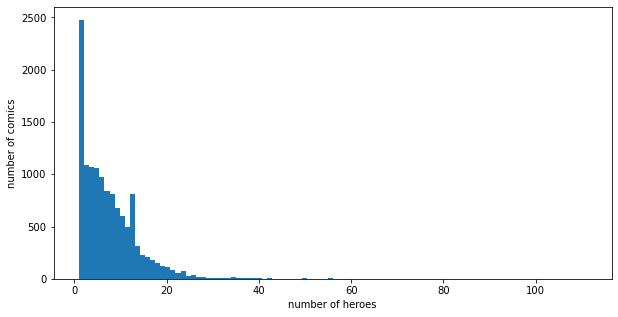

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(hero_appeard['hero'], bins=100)
plt.xlabel('number of heroes')
plt.ylabel('number of comics')
plt.show()
# plot the distribution of the number of heroes that have appeared in each comic of G2

A plot depicting the degree distribution of the network


In [ ]:
plt.figure(figsize=(10,5))
plt.hist(degree_G1, bins=50)
plt.xlabel('degree')
plt.ylabel('number of nodes')
plt.show()
#plot depicting the degree distribution of the network G1

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(*zip(*sorted_degree_G1[:50]))
plt.xlabel('degree')
plt.ylabel('number of nodes')
plt.show()
# with the first 50 heroes of G1 and depicting the degree distribution of the networ

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(sorted_degreeG2, bins=50)
plt.xlim(10, 400)
plt.xlabel('degree')
plt.ylabel('number of nodes')
plt.show()

In [ ]:
plt.xscale()
plt.xlabel('degree')
plt.ylabel('number of nodes')
plt.show()
#plot depicting the degree distribution of the network G2

### Visualization 2 - Visualize centrality measure

A table containing the information related to the requested centrality measure for:
- The average of the requested centrality measure for all of the network's nodes

In [308]:
betweenness_centrality_dict = dict( fun_betweenness_centrality(G))
def avg_betweenness_centrality(G):
    return sum(betweenness_centrality_dict.values())/len(betweenness_centrality_dict)
print("Average of betweenness centrality of the graph: ", avg_betweenness_centrality(G))
data_betweenness = {node: avg_betweenness_centrality(G) for node in G.nodes()}
df_betweenness= pd.DataFrame.from_dict(data_betweenness, orient='index', columns=['Average betweenness centrality'])

Average of betweenness centrality of G2:  3.4147992016459226e-08


In [309]:
pagereank_centrality_dict = dict( fun_pagerank_centrality(G))

def avg_pagerank_centrality(G):
    return sum(pagereank_centrality_dict.values())/len(pagereank_centrality_dict)
print("Average of pagerank centrality of G2: ", avg_pagerank_centrality(G))

data_pagerank= {node: avg_pagerank_centrality(G) for node in G.nodes()}
df_pagerank= pd.DataFrame.from_dict(data_pagerank, orient='index', columns=['Average pagerank centrality'])


Average of pagerank centrality of G2:  5.239155862424604e-05


In [331]:
def fun_degree_centrality(G):
  degree_centrality = {}
  for node in G.nodes():
    num_neighbors = len(list(G.neighbors(node)))
    degree_centrality[node] = num_neighbors / (len(G) - 1)
  return degree_centrality

degree_centrality_dict = fun_degree_centrality(G)

def avg_degree_centrality(degree_centrality):
  total = 0
  for value in degree_centrality.values():
    total += value
  return total / len(degree_centrality)

print("Average of degree centrality of the graph: ", avg_degree_centrality(degree_centrality_dict))

Average of degree centrality of G2:  0.0005276116150449991


In [ ]:
def avg_closeness_centrality(G):
  total_closeness = 0
  for node in G.nodes():
    total_closeness += fun_closeness_centrality(G, node)
  return total_closeness / len(G)

print("Average of closeness centrality of G2: ", avg_closeness_centrality(G))

In [ ]:
# oppuree
#def avg_closeness_centrality(G2, node):
  #total_closeness = 0
  #for n in G2.nodes():
    #total_closeness += fun_closeness_centrality(G2, n)
  #return total_closeness / len(G2)

#data_closeness_G2 = {node: avg_closeness_centrality(G2, node) for node in G2.nodes()}
#df_closeness_G2 = pd.DataFrame.from_dict(data_closeness_G2, orient='index', columns=['Average closeness centrality'])

In [ ]:
#create a table of average degree centrality for all nodes of G
data_degree = {node: avg_degree_centrality(degree_centrality_dict) for node in G.nodes()}
df_degree= pd.DataFrame.from_dict(data_degree, orient='index', columns=['Average degree centrality'])
#print the table of average degree centrality for all nodes of G
print(df_degree)

- The requested centrality measure's value for the given node

In [ ]:
def fun_centrality_table(G, node, measure="betweenness"):
  if measure == "betweenness":
    # Define the function fun_betweenness_centrality here
    centrality = fun_betweenness_centrality(G, node)
  elif measure == "pagerank":
    # Define the function fun_pagerank_centrality here
    centrality = fun_pagerank_centrality(G, node)
  elif measure == "degree":
    # Define the function fun_degree_centrality here
    centrality = fun_degree_centrality(G, node)
  elif measure == "closeness":
    # Calcola la centralità di prossimità del nodo
    centrality = fun_closeness_centrality(G, node)
  else:
    raise ValueError("Misura di centralità non supportata")
  df_centrality = pd.DataFrame(centrality, index=[0])
  return df_centrality

# Example usage of the function
df_centrality = fun_centrality_table(G, node, measure)
print(df_centrality)



In [ ]:
# Calculate the degree centrality for all nodes in the graph
degree_centrality = {node: fun_degree_centrality(G) for node in list(G.nodes())[:10]}

# Convert the degree centrality dictionary to a Pandas dataframe
df_degree = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['Degree centrality'])

# Display the table
print(df_degree)

In [ ]:
# calculate just for the first 10 nodes
closeness_centrality = {node: fun_closeness_centrality(G, node) for node in list(G.nodes())[:10]}
# Convert the closeness centrality dictionary to a Pandas dataframe
df_closeness = pd.DataFrame.from_dict(closeness_centrality, orient='index', columns=['Closeness centrality'])

# Display the table
print(df_closeness)

In [ ]:
df_betweenness = pd.DataFrame.from_dict(fun_betweenness_centrality, orient='index', columns=['Betweenness centrality'])
print(df_betweenness)
df_pagerank = pd.DataFrame.from_dict(fun_pagerank_centrality, orient='index', columns=['Pagerank centrality'])
print(df_pagerank)
df_closeness = pd.DataFrame.from_dict(fun_closeness_centrality, orient='index', columns=['Closeness centrality'])
print(df_closeness)